# LSTM Model using Therapy sequence

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Input, concatenate, Reshape, Activation, Flatten, Add, BatchNormalization, Multiply, LeakyReLU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC, SensitivityAtSpecificity
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, Adamax, SGD, Adadelta
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import L1L2, L1, L2
from livelossplot import PlotLossesKeras
#internal validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle

# fix random seed for reproducibility
tf.random.set_seed(1234)

target_outcome = '12months'
max_codes = 300

2023-12-01 10:37:56.594276: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 10:37:56.664628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 10:37:56.664680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 10:37:56.664704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 10:37:56.675769: I tensorflow/core/platform/cpu_feature_g

In [ ]:
# load the dataset but only keep the top n words, zero the rest
data = pickle.load(open('../SeqModel/data_all_big_08112023_75%.sav', 'rb'))
code2idx = pickle.load(open('../SeqModel/code2idx_all_big_08112023_75%.sav', 'rb'))
idx2code = pickle.load(open('../SeqModel/idx2code_all_big_08112023_75%.sav', 'rb'))

vocab_size = len(code2idx)
vocab_size

In [ ]:
tabularData = pd.read_csv('../FinalData/cleaned_features_08112023.csv')
tabularData = tabularData.drop_duplicates(subset=['patid'])

extractVars = ['patid', 'sex', 'BMI', 'imd_decile', 'smokingStatus', 'month_1', 'month_2', 'month_3',
 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
 'month_10', 'month_11', 'month_12', ]

data = data.merge(tabularData[extractVars], how = 'left', on='patid')
data = pd.get_dummies(data, columns=['imd_decile', 'smokingStatus']) #one hot encoding
tabularData = []

In [ ]:
# #Data split conventional (mixed countries)
# trainingData, testData = train_test_split(data, test_size=0.1, stratify=data[target_outcome], random_state=1234)
# trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
# print(trainingData.shape)
# print(valData.shape)
# print(testData.shape)

In [ ]:
#Data split, train=England, eval=Scot+Wales
trainingData = data[(data.Country == 'England') & (data.age >= 18)]
trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
trainingData, evalData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
testData = data[((data.Country == 'Wales') | (data.Country == 'Scotland')) & (data.age >= 18)]
testDataWales = data[(data.Country == 'Wales') & (data.age >= 18)]
testDataScotland = data[(data.Country == 'Scotland') & (data.age >= 18)]

In [ ]:
print('Train: ', trainingData.shape[0])
print('Val: ', valData.shape[0])
print('Eval (internal validation): ', evalData.shape[0])
print('Test: ', testData.shape[0])
print('Test - Wales: ', testDataWales.shape[0])
print('Test - Scotland: ', testDataScotland.shape[0])

In [ ]:
print(trainingData.patid.unique().shape)
print(trainingData.shape)

In [ ]:
#make sure no data leak between sets
print(list(set(trainingData.patid.values).intersection(set(valData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(evalData.patid.values))))
print(list(set(valData.patid.values).intersection(set(evalData.patid.values))))
print(list(set(valData.patid.values).intersection(set(testData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(testData.patid.values))))
print(list(set(testData.patid.values).intersection(set(testDataScotland.patid.values)))) # here data leak is expected

In [ ]:
print(trainingData[target_outcome].value_counts(normalize=True))
print(valData[target_outcome].value_counts(normalize=True))
print(evalData[target_outcome].value_counts(normalize=True))
print(testData[target_outcome].value_counts(normalize=True))
print(testDataWales[target_outcome].value_counts(normalize=True))
print(testDataScotland[target_outcome].value_counts(normalize=True))

In [ ]:
tabularVars = ['age', 'sex', 'BMI', 'smokingStatus_Active Smoker', 
                   'smokingStatus_Former Smoker', 'smokingStatus_Non Smoker',
                   'imd_decile_0.0', 'imd_decile_1.0', 'imd_decile_2.0', 'imd_decile_3.0',
                   'imd_decile_4.0', 'imd_decile_5.0', 'imd_decile_6.0', 'imd_decile_7.0',
                   'imd_decile_8.0', 'imd_decile_9.0', 'imd_decile_10.0', 
                   # 'month_1', 'month_2', 'month_3','month_4', 'month_5', 
                   # 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
                   # 'month_11', 'month_12',
                  ]
Xt_train = np.array(trainingData[tabularVars].values)
Xt_val = np.array(valData[tabularVars].values)
Xt_eval = np.array(evalData[tabularVars].values)
Xt_test = np.array(testData[tabularVars].values)
Xt_testWales = np.array(testDataWales[tabularVars].values)
Xt_testScotland= np.array(testDataScotland[tabularVars].values)

Xs_train = np.array(trainingData.read_code_seq_padded_idx_end.values)
Xs_train = np.array([x for x in Xs_train])
Xs_val = np.array(valData.read_code_seq_padded_idx_end.values)
Xs_val = np.array([x for x in Xs_val])
Xs_eval = np.array(evalData.read_code_seq_padded_idx_end.values)
Xs_eval = np.array([x for x in Xs_eval])
Xs_test = np.array(testData.read_code_seq_padded_idx_end.values)
Xs_test = np.array([x for x in Xs_test])
Xs_testWales = np.array(testDataWales.read_code_seq_padded_idx_end.values)
Xs_testWales = np.array([x for x in Xs_testWales])
Xs_testScotland = np.array(testDataScotland.read_code_seq_padded_idx_end.values)
Xs_testScotland = np.array([x for x in Xs_testScotland])

Xm_train = np.array(trainingData.month_padded_idx_end.values)
Xm_train = np.array([x for x in Xm_train])
Xm_val = np.array(valData.month_padded_idx_end.values)
Xm_val = np.array([x for x in Xm_val])
Xm_eval = np.array(evalData.month_padded_idx_end.values)
Xm_eval = np.array([x for x in Xm_eval])
Xm_test = np.array(testData.month_padded_idx_end.values)
Xm_test = np.array([x for x in Xm_test])
Xm_testWales = np.array(testDataWales.month_padded_idx_end.values)
Xm_testWales = np.array([x for x in Xm_testWales])
Xm_testScotland = np.array(testDataScotland.month_padded_idx_end.values)
Xm_testScotland = np.array([x for x in Xm_testScotland])

y_train = trainingData[target_outcome].values
y_val = valData[target_outcome].values
y_eval = evalData[target_outcome].values
y_test = testData[target_outcome].values
y_testWales = testDataWales[target_outcome].values
y_testScotland = testDataScotland[target_outcome].values

#scalling tabular data
scaler = StandardScaler().fit(Xt_train)
Xt_train = scaler.transform(Xt_train)
Xt_val = scaler.transform(Xt_val)
Xt_eval = scaler.transform(Xt_eval)
Xt_test = scaler.transform(Xt_test)
Xt_testWales = scaler.transform(Xt_testWales)
Xt_testScotland = scaler.transform(Xt_testScotland)

In [ ]:
# # X and y
# X_train = np.array(trainingData.read_code_seq_padded_idx.values)
# X_train = np.array([x for x in X_train])
# X_val = np.array(valData.read_code_seq_padded_idx.values)
# X_val = np.array([x for x in X_val])
# X_eval = np.array(evalData.read_code_seq_padded_idx.values)
# X_eval = np.array([x for x in X_eval])
# X_test = np.array(testData.read_code_seq_padded_idx.values)
# X_test = np.array([x for x in X_test])
# X_testWales = np.array(testDataWales.read_code_seq_padded_idx.values)
# X_testWales = np.array([x for x in X_testWales])
# X_testScotland = np.array(testDataScotland.read_code_seq_padded_idx.values)
# X_testScotland = np.array([x for x in X_testScotland])

# y_train = trainingData[target_outcome].values
# y_val = valData[target_outcome].values
# y_eval = evalData[target_outcome].values
# y_test = testData[target_outcome].values
# y_testWales = testDataWales[target_outcome].values
# y_testScotland = testDataScotland[target_outcome].values

# RUN

In [2]:
sets =  pickle.load(open('../SeqModel/sets_search_long.sav', 'rb'))
code2idx = pickle.load(open('../SeqModel/all_vocab.sav', 'rb'))
month2idx = pickle.load(open('../SeqModel/all_vocab_month.sav', 'rb'))
vocab_size = len(code2idx)
month_size = len(month2idx)
print(vocab_size)
print(month_size)

67481
12


In [3]:
Xt_train, Xt_val, Xs_train, Xs_val, Xm_train, Xm_val, y_train, y_val = sets

In [4]:
print('Train: ', Xs_train.shape)
print('Val: ', Xs_val.shape[0])
# print('Eval (internal validation): ', Xs_eval.shape[0])
# print('Test: ', Xs_test.shape[0])
# print('Test - Wales: ', Xs_testWales.shape[0])
# print('Test - Scotland: ', Xs_testScotland.shape[0])

Train:  (17693, 1500)
Val:  9480


In [5]:
pos_weight = sum(x == 0 for x in y_train)/sum(x == 1 for x in y_train)
class_weight = {0:1, 1:pos_weight}
print(class_weight)

{0: 1, 1: 5.005770536320434}


In [6]:
np.sqrt(vocab_size)

259.77105304479176

In [19]:
def earlyFussion():
       
    inputs1 = Input(shape=(Xt_train.shape[1],))
    inputs2 = Input(shape=(Xs_train.shape[1],))
    inputs3 = Input(shape=(Xm_train.shape[1],))
    
    
    #clinical embedding for lstm
    embedding = Embedding(vocab_size, 200, input_length=1500)(inputs2)
    
    #month embedding for lstm
    embedding_month = Embedding(month_size, 7, input_length=1500)(inputs3)
    
    nn = Dense(64, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(l1=0.0, l2=0.01))(inputs1)
    nn = Dropout(0.5)(nn)
    lstmClinical = LSTM(units=64, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(embedding)
    lstmMonth = LSTM(units=64, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(embedding_month)
    lstm = Multiply()([lstmClinical, lstmMonth])
    # lstm = lstmClinical
    
    nn = Reshape((1, 64))(nn)
    add = concatenate([nn, lstm], axis=1)
    nn = Dense(32, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(l1=0.0, l2=0.01))(add)
    nn = Dropout(0.5)(nn)
    lstm = LSTM(units=32, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(lstm)
    
    # nn = Reshape((301, 64))(nn)
    add = concatenate([nn, lstm], axis=1)
    nn = Dense(16, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(l1=0.0, l2=0.01))(add)
    nn = Dropout(0.5)(nn)
    lstm = LSTM(units=16, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(lstm)
    
    model_tot = concatenate([nn, lstm], axis=1)
    model_tot = BatchNormalization()(model_tot)

    model_tot = Dense(units=16, activation=LeakyReLU())(model_tot)
    
    model_tot = Flatten()(model_tot)
    output = Dense(1, activation='sigmoid')(model_tot)
    
    opt = Adamax(learning_rate=1e-3, clipvalue=.5)
    metrics = [
        AUC(num_thresholds=3, name='auc', curve='ROC'),
        AUC(num_thresholds=3, name='auprc', curve='PR'),
        tf.keras.metrics.Precision(name='prec'),
        tf.keras.metrics.Recall(name='rec'),
        tf.keras.metrics.TrueNegatives(name='TN'),
        tf.keras.metrics.TruePositives(name='TP'),
        tf.keras.metrics.PrecisionAtRecall(0.8)
    ]
    
    loss = tf.keras.losses.BinaryCrossentropy()
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)
    model.compile(
        loss='binary_crossentropy', 
        optimizer=opt, 
        metrics=metrics)
    return model

In [20]:
# from sklearn.utils import class_weight
# sklearn_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight = dict(enumerate(sklearn_weights))

#Hyperparameter
lr = 1e-5
clipvalue = 0.2
epoch = 1000
batch_size = 256
embedding_vector_length = 50
month_embedding_vector_length = 5
# embedding_vector_length = int(np.sqrt(vocab_size))
# embedding_vector_length = int(np.cbrt(vocab_size))
print(embedding_vector_length)

50


In [21]:
#visualise model
model = earlyFussion()
# model = earlyFussion()
print(model.summary())



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 20)]                 0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1500)]               0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1500)]               0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 64)                   1344      ['input_10[0][0]']            
                                                                                            

In [22]:
%%time
# TF_GPU_ALLOCATOR=cuda_malloc_async

#training
with tf.device('/GPU:0'):
    earlyStopping = EarlyStopping(monitor='val_auc', patience=5, verbose=0, mode='max', restore_best_weights=True)
    mcp_save = ModelCheckpoint('../SeqModel/seqModel_therapy_tabSeq.mdl_wts.hdf5', save_best_only=True, monitor='val_auc', mode='min')
    history = model.fit([Xt_train, Xs_train, Xm_train], y_train, validation_data=([Xt_val, Xs_val, Xm_val], y_val), 
                            epochs=epoch, batch_size=128, 
                        class_weight = class_weight, 
                        callbacks = [earlyStopping, mcp_save])

Epoch 1/1000
139/139 [==============================] - ETA: 0s - loss: 3.2551 - auc: 0.5720 - auprc: 0.1991 - prec: 0.2116 - rec: 0.5631 - TN: 8566.0000 - TP: 1659.0000 - precision_at_recall_3: 0.1881

/opt/conda/envs/rapids/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 68s 446ms/step - loss: 3.2551 - auc: 0.5720 - auprc: 0.1991 - prec: 0.2116 - rec: 0.5631 - TN: 8566.0000 - TP: 1659.0000 - precision_at_recall_3: 0.1881 - val_loss: 1.6405 - val_auc: 0.5000 - val_auprc: 0.1666 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_TN: 7901.0000 - val_TP: 0.0000e+00 - val_precision_at_recall_3: 0.1886
Epoch 2/1000
139/139 [==============================] - 60s 435ms/step - loss: 1.9394 - auc: 0.5931 - auprc: 0.2093 - prec: 0.2231 - rec: 0.6113 - TN: 8477.0000 - TP: 1801.0000 - precision_at_recall_3: 0.1953 - val_loss: 1.2957 - val_auc: 0.5000 - val_auprc: 0.1666 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_TN: 7901.0000 - val_TP: 0.0000e+00 - val_precision_at_recall_3: 0.2053
Epoch 3/1000
139/139 [==============================] - 60s 428ms/step - loss: 1.6936 - auc: 0.5981 - auprc: 0.2120 - prec: 0.2264 - rec: 0.6185 - TN: 8520.0000 - TP: 1822.0000 - precision_at_recall_3: 0.2000 - val_loss: 1.2192 - val_auc

In [ ]:
# %%time

# # create the model
# embedding_vector_length = 50
# earlyStopping = EarlyStopping(monitor='val_auc', patience=10, verbose=0, mode='max', restore_best_weights=True)
# mcp_save = ModelCheckpoint('../SeqModel/seqModel_therapy.mdl_wts.hdf5', save_best_only=True, monitor='val_auc', mode='min')

# with tf.device('/GPU:0'):
#     model = Sequential()
#     model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_codes))
#     model.add(LSTM(128, return_sequences=True, kernel_regularizer=L1L2(l1=0.02, l2=0.03)))
#     model.add(Dropout(0.5))
#     model.add(LSTM(64,  kernel_regularizer=L1L2(l1=0.02, l2=0.03)))
#     model.add(Dropout(0.5))
#     model.add(Dense(32, activation=LeakyReLU(alpha=.3), kernel_regularizer=L1L2(l1=0.02, l2=0.03)))
#     model.add(Dense(1, activation='sigmoid'))
#     opt = Adadelta(learning_rate=5e-3, clipvalue=0.3)
#     metrics = [
#         AUC(num_thresholds=3, name='auc'),
#     ]
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics, )
#     print(model.summary())
#     history = model.fit(Xs_train, y_train, validation_data=(Xs_val, y_val), epochs=30, batch_size=128, class_weight = class_weight, callbacks = [earlyStopping, mcp_save])

dict_keys(['loss', 'auc', 'auprc', 'prec', 'rec', 'TN', 'TP', 'precision_at_recall_3', 'val_loss', 'val_auc', 'val_auprc', 'val_prec', 'val_rec', 'val_TN', 'val_TP', 'val_precision_at_recall_3'])


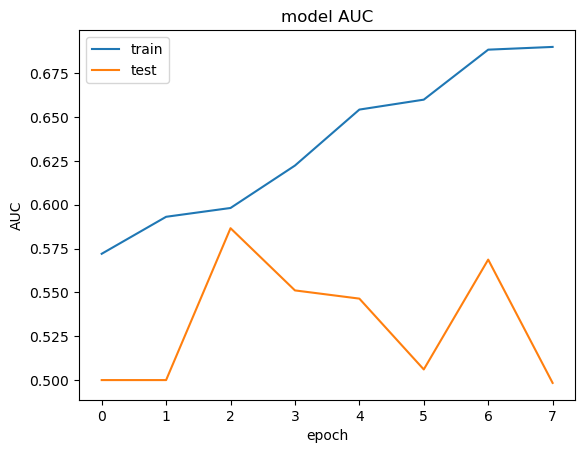

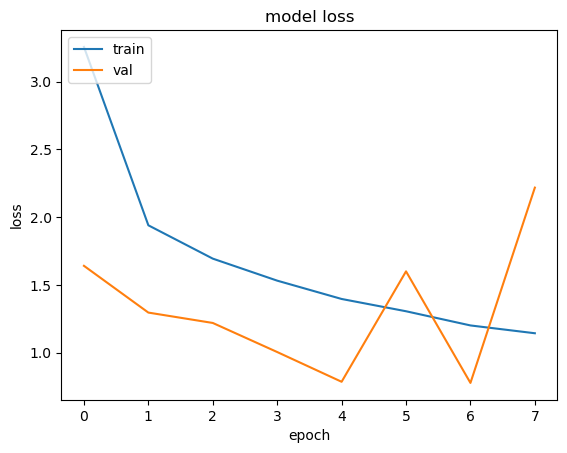

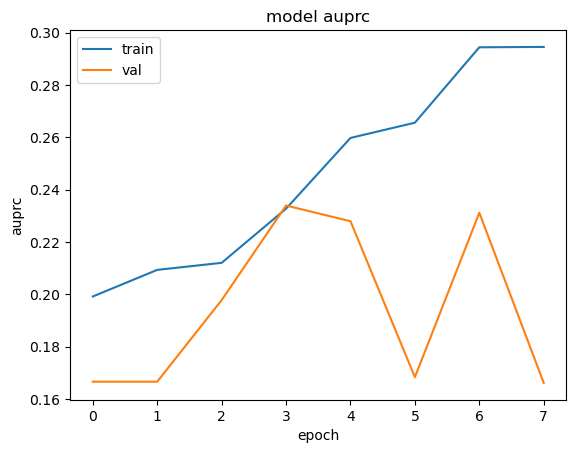

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylim(0.3, 1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['auprc'])
plt.plot(history.history['val_auprc'])
plt.title('model auprc')
# plt.ylim(0.3, 1)
plt.ylabel('auprc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
with tf.device('/CPU:0'):
    model.evaluate(X_eval, y_eval)
    model.evaluate(X_test, y_test)
    model.evaluate(X_testWales, y_testWales)
    model.evaluate(X_testScotland, y_testScotland)

NameError: name 'X_eval' is not defined

In [ ]:
#Model evaluation function
def summariseResult (testY, preds):
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    aucscore = auc(fpr, tpr)
    # aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

data_test_Xs = [X_eval, X_test, X_testWales, X_testScotland]
data_test_ys = [y_eval, y_test, y_testWales, y_testScotland]
for data_test_X, data_test_y in zip(data_test_Xs, data_test_ys):
    with tf.device('/CPU:0'):
        preds = model.predict(data_test_X)
    preds = [0 if pred <0.5 else 1 for pred in preds]
    print(summariseResult(data_test_y, np.squeeze(preds)))

In [ ]:
model.save('../SeqModel/model_therapy.h5')

In [ ]:
# from keras.models import load_model
# a = load_model('../SeqModel/my_model.h5')